# Disaster Tweet Analyzer with Extended Data Preprocessing and Feature Engineering
This notebook will walk through data loading, extensive cleaning, feature engineering, and preparation for model training for the Disaster Tweet Analyzer project. The steps include:
1. Importing Libraries
2. Loading and Exploring the Dataset
3. Data Cleaning and Text Preprocessing
4. Handling Missing Values
5. Handling Class Imbalance
6. Feature Engineering
7. Saving Cleaned Data and Preparing for Model Training


In [57]:
# Import Libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.utils import resample

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KAUSHAL/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KAUSHAL/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\KAUSHAL/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Step 1: Import Libraries
We import essential libraries for data manipulation, text processing, visualization, and handling class imbalance.


In [58]:
# Data Acquisition from CSV File
data = pd.read_csv('tweets.csv')
data.head()


,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


In [59]:
data = data.drop(columns=['id'])

### Step 2: Load the Dataset
We load the dataset and display the first few rows to get an initial look at the data structure.


In [60]:
#Check Data Shape and Missing Values
print("Data Shape:", data.shape)
print("Missing Values:\n", data.isnull().sum())


Data Shape: (11370, 4)
Missing Values:
 keyword        0
location    3418
text           0
target         0
dtype: int64


### Step 3: Basic Data Overview
Check the shape of the dataset and identify missing values in each column.


In [61]:
# Explore Target Class Distribution
print("Target Class Distribution:\n", data['target'].value_counts())


Target Class Distribution:
 target
0    9256
1    2114
Name: count, dtype: int64


### Step 4: Explore Target Class Distribution
Check the distribution of the target classes.

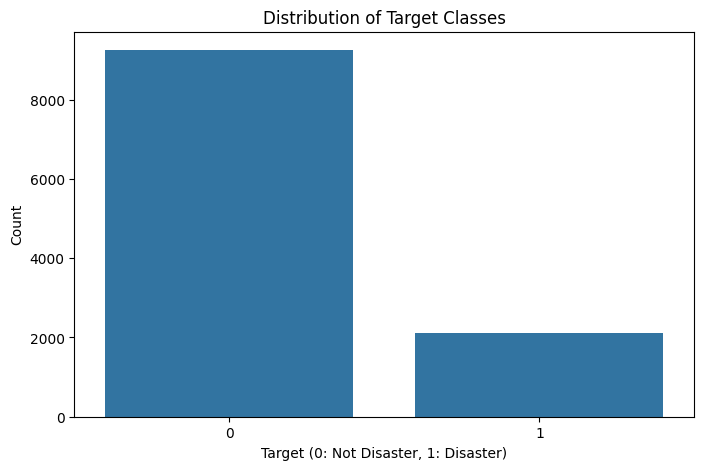

In [62]:
# Visualize Target Class Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='target', data=data)
plt.title('Distribution of Target Classes')
plt.xlabel('Target (0: Not Disaster, 1: Disaster)')
plt.ylabel('Count')
plt.show()


### Step 5: Text Cleaning
Define a function to clean tweet text by removing URLs, mentions, and special characters, and apply it to the dataset.

In [78]:
# Data Cleaning - Clean Text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r"\b\w{1,2}\b", "", text)
    return text

data['text'] = data['text'].apply(clean_text)

### Step 6: Expand Contractions and Handle Emojis
Expand contractions and convert emojis to text for further clarity.



In [79]:
# Additional Data Cleaning Steps
import contractions
data['text'] = data['text'].apply(lambda x: contractions.fix(x))

from emoji import demojize
data['text'] = data['text'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))
data['text'] = data['text'].apply(lambda x: demojize(x))
data['text'] = data['text'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

### Step 7: Remove Stopwords
Define a function to remove common English stopwords from the text.

In [80]:
# Data Cleaning - Remove Stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

data['text'] = data['text'].apply(remove_stopwords)

### Step 8: Lemmatize Text
Lemmatize each word to reduce it to its base form, aiding in model accuracy.

In [81]:
# Data Cleaning - Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

data['text'] = data['text'].apply(lemmatize_text)

### Step 9: Remove Duplicates and Calculate Text Length
Remove duplicate tweets and create a column for tweet length.

In [82]:
# Remove Duplicates and Analyze Text Length
initial_rows = data.shape[0]
data = data.drop_duplicates(subset='text', keep='first')
final_rows = data.shape[0]
print(f"Duplicates removed: {initial_rows - final_rows}, Remaining rows: {final_rows}")

data['text_length'] = data['text'].apply(len)

Duplicates removed: 3, Remaining rows: 10759


### Step 10: Visualize Distribution of Tweet Lengths
Plot the distribution of tweet lengths to understand tweet characteristics.

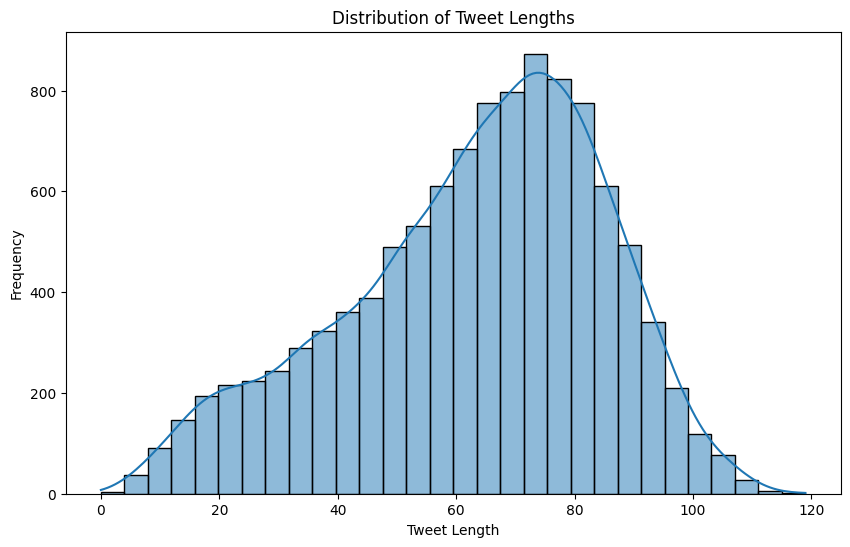

In [83]:
# Visualize Distribution of Tweet Lengths
plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], bins=30, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

### Step 11: Handle Missing Values in Location Column
Fill missing values in the 'location' column with 'Unknown'.

In [84]:
# Handling Missing Values in Location Column
data['location'].fillna('Unknown', inplace=True)

C:\Users\KAUSHAL\AppData\Local\Temp\ipykernel_5480\2006056358.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['location'].fillna('Unknown', inplace=True)


### Step 12: Handle Class Imbalance
Use upsampling to balance the target classes for more accurate model training.

In [85]:
# Handle Class Imbalance
disaster_tweets = data[data['target'] == 1]
non_disaster_tweets = data[data['target'] == 0]

disaster_tweets_upsampled = resample(disaster_tweets,
                                     replace=True,
                                     n_samples=len(non_disaster_tweets),
                                     random_state=42)
data_balanced = pd.concat([disaster_tweets_upsampled, non_disaster_tweets])

print("Balanced Target Class Distribution:\n", data_balanced['target'].value_counts())

Balanced Target Class Distribution:
 target
1    8866
0    8866
Name: count, dtype: int64


### Step 13: Basic Feature Engineering
Calculate word count, character count, and average word length for each tweet.

In [86]:
# Feature Engineering - Word Count, Character Count, Average Word Length
data_balanced['word_count'] = data_balanced['text'].apply(lambda x: len(x.split()))
data_balanced['char_count'] = data_balanced['text'].apply(len)
data_balanced['avg_word_length'] = data_balanced['char_count'] / data_balanced['word_count']

### Step 14: Additional Feature Engineering
Calculate punctuation count and uppercase word count to add further features for the model.

In [87]:
# Additional Feature Engineering - Punctuation and Uppercase Word Count
def count_punctuation(text):
    return len(re.findall(r'[^\w\s]', text))

def count_uppercase_words(text):
    words = text.split()
    uppercase_words = [word for word in words if word.isupper()]
    return len(uppercase_words)

data_balanced['punctuation_count'] = data_balanced['text'].apply(count_punctuation)
data_balanced['uppercase_word_count'] = data_balanced['text'].apply(count_uppercase_words)

### Step 15: Vectorization
Convert text data into numerical features using TF-IDF.

In [88]:
# Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Add missing columns with default values
if 'hashtag_count' not in data_balanced.columns:
    data_balanced['hashtag_count'] = 0
if 'url_count' not in data_balanced.columns:
    data_balanced['url_count'] = 0

# Ensure all required columns are present
required_columns = ['text', 'word_count', 'char_count', 'avg_word_length', 
                    'punctuation_count', 'hashtag_count', 'uppercase_word_count', 'url_count', 'target']
missing_columns = [col for col in required_columns if col not in data_balanced.columns]
if missing_columns:
    raise ValueError(f"Missing columns in data_balanced: {missing_columns}")

# Check for missing values in the 'text' column
if data_balanced['text'].isnull().any():
    raise ValueError("Missing values found in 'text' column")

# Ensure the 'text' column is of type str
data_balanced['text'] = data_balanced['text'].astype(str)

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 features for efficiency

# Fit and transform the 'text' column to create the document-term matrix
X_vectorized = vectorizer.fit_transform(data_balanced['text']).toarray()

# Convert to DataFrame for easier handling
X_vectorized_df = pd.DataFrame(X_vectorized, columns=vectorizer.get_feature_names_out())

# Concatenate with other features if needed (like word_count, char_count, etc.)
X = pd.concat([X_vectorized_df, data_balanced[['word_count', 'char_count', 'avg_word_length', 
                                                'punctuation_count', 'hashtag_count', 
                                                'uppercase_word_count', 'url_count']].reset_index(drop=True)], axis=1)

# The target variable remains unchanged
y = data_balanced['target']

print("Vectorization complete. Data is ready for model training.")

Vectorization complete. Data is ready for model training.


### Step 16: Save Cleaned Data
Save the processed data to a CSV file for future use in model training.

In [89]:
# Save Cleaned and Balanced Dataset
data_balanced.to_csv('cleaned_balanced_disaster_tweets.csv', index=False)
print("Processed data saved as 'cleaned_balanced_disaster_tweets.csv'.")

Processed data saved as 'cleaned_balanced_disaster_tweets.csv'.


### Step 17: Data Preparation for Model Training
Split data into features (X) and target (y) for model training.

In [90]:
from sklearn.model_selection import train_test_split

# Prepare for Model Training
X = data_balanced.drop(['target'], axis=1)
y = data_balanced['target']
print("Data ready for model training.")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Data ready for model training.
Training set size: (14185, 11)
Testing set size: (3547, 11)


### Step 18: Train and Evaluate the Model
Train a logistic regression model and evaluate its performance.

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Identify non-numeric columns
non_numeric_cols = X_train.select_dtypes(include=['object']).columns

# Create a column transformer to handle non-numeric columns and impute missing values
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
            ('scaler', 'passthrough')  # Keep numeric columns as is
        ]), X_train.select_dtypes(exclude=['object']).columns),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Impute missing values with 'missing'
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical columns
        ]), non_numeric_cols)
    ])

# Create a pipeline with the preprocessor and the logistic regression model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Accuracy: 0.9097829151395546
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91      1790
           1       0.87      0.95      0.91      1757

    accuracy                           0.91      3547
   macro avg       0.91      0.91      0.91      3547
weighted avg       0.91      0.91      0.91      3547



c:\Users\KAUSHAL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Summary of Work Done

In this notebook, we have:

1. **Loaded and Explored** the dataset to understand its structure and class distribution.
2. **Cleaned the Text Data** by removing URLs, mentions, special characters, and stopwords, along with lemmatization.
3. **Handled Missing Values** by filling gaps in specific columns.
4. **Balanced the Dataset** using upsampling to manage class imbalance.
5. **Engineered Additional Features** such as tweet length, punctuation count, and uppercase word count.
6. **Saved the Cleaned and Balanced Data** to a new CSV file.
7. **Prepared the Data for Model Training** by separating features (X) and the target (y).
8. **Vectorized the Text Data** using TF-IDF to convert text into numerical features.
9. **Handled Non-Numeric Columns and Missing Values** using a column transformer and imputer in a pipeline.
10. **Trained a Logistic Regression Model** on the processed data.
11. **Evaluated the Model** using accuracy score and classification report.

The data is now ready for training machine learning models to classify disaster-related tweets accurately.
